# Introduction to the Patent Topic Modelling Project

This jupyter notebook acts as an introduction to the Patent Topic Modelling project and follows the CRIPS-DM-Methodology.
Parts of this notebook are featured in the README as well, while parts of its code were refactored and used to construct the other scripts.

## Motivation

Patents primarily use is the protection of inventions or products and by that the support of further technological development. Patent protection is an import mechanic for companies, as it forms a legal framework and thus secures the proprietors rights. However, patent content can also be an important source of information,as it reflects the companies portfolio and technological abilities.  By that patens can influence business decisions and predict or suggest possible future trends or innovations.

Goal of this project is to process digitalized patent data, analyze the content and to build a functioning model which can discover latent, hidden topics which are in the text data of the patents. The model is build on the Latent Direchlet Allocation, as this is one of the most popular and widely used topic modelling algorithms.


## Dataset
In order to build a functioning topic model, bulk patent data is necessary. In addition, this data should be open acess as well for this project. 

- Google Patents: Scrapped patent information, but the open acess bulk data was discontinuied a few years ago.
- European Patent Office (EPO): offers an "Open Patent Service" (OPS) which is not open acess
https://www.epo.org/searching-for-patents/data/web-services/ops_de.html 
- United States Patent and Trading Office (USPO): offers free and openacess bulk patent data with and without API.

Since only the UPSTO data fullfills our requirements and is is easiest acessable, we'll employ the USPTO data. The full patent data is extremely large and exceeds the scope of this project for now:
- Full Bulk data download link: https://www.patentsview.org/download/claims.html
- Examplerly patent data download link: https://developer.uspto.gov/data?search_api_fulltext=&sort_by=field_version_and_date&page=0

We focuse on the *"Patent application full text data/XML"* data set as updated on 2020-07-06 with roughly 151.55 MB. The data comes in a single ipa200709.zip file, which contains all patents in a large ipa200709.xml. This will be our testing ground or proof of principle.

Since patents are text documents they are stored in xml files. However, due to the beaurocratic nature of patent offices and the sheer amount of patents, the formatting of these files can be messy and inconsistent. 

## CRISP-DM Methodology
1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modelling
5. Evaluation
6. Deployment

# 1) Business Understanding

Before we can analyze the data, we first need to understand the information stored in patents and which information is relevant for our project.

The xml files are in accordance with Patent Application Version 4.4 International Common Element (ICE) Document Type Definition (DTD). This gives us the information, how to read the files and which information is relevant to us.

Panten classifcation of the USPTO: https://www.uspto.gov/patents-application-process/patent-search/classification-standards-and-developmenthttps://www.uspto.gov/patents-application-process/patent-search/classification-standards-and-development

CPC - Cooperative Patent Classification:

* A: Human Necessities
* B: Operations and Transport
* C: Chemistry and Metallurgy
* D: Textiles
* E: Fixed Constructions
* F: Mechanical Engineering
* G: Physics
* H: Electricity
* Y: Emerging Cross-Sectional Technologies

These sections are further categorized: Section/Class/Subclass/Group/Maingroup and subgroups. 
The quicksearch can be used to understand the patent formats bettter: http://patft.uspto.gov/netahtml/PTO/search-bool.

More useful information are application and publication dates, titles and abstracts of the patents as well as the companies behind the patents. Since we want to discover latent topics in the text, we need to analyze both the descriptive text and the claim text.




# 2) Data Understanding
Lets analyze the data and see what is actually in the files.

In [4]:
# Dependencies
import os
import numpy as np
import pandas as pd
import xml.etree.ElementTree as etree  # python default xml parser
from bs4 import BeautifulSoup # very elegant parser, used in addition to xml

# My locale file path
localPath = r'C:\Users\marti\Dropbox\Promotion\Fortbildung\Udacity\Nanodegree\Projekt4\TopicModelling\Code-Bausteine'
fullTextData = localPath + "\Datasets\ipa200709.xml"

In [2]:
# Lets read in first in pure pythonical way without any fancy libraries to scout for any data problems
f = open(fullTextData, "r")
for i in range(20):
       line = f.readline()
       print('line: ', i,  line)
f.close()

line:  0 <?xml version="1.0" encoding="UTF-8"?>

line:  1 <!DOCTYPE us-patent-application SYSTEM "us-patent-application-v44-2014-04-03.dtd" [ ]>

line:  2 <us-patent-application lang="EN" dtd-version="v4.4 2014-04-03" file="US20200214189A1-20200709.XML" status="PRODUCTION" id="us-patent-application" country="US" date-produced="20200624" date-publ="20200709">

line:  3 <us-bibliographic-data-application lang="EN" country="US">

line:  4 <publication-reference>

line:  5 <document-id>

line:  6 <country>US</country>

line:  7 <doc-number>20200214189</doc-number>

line:  8 <kind>A1</kind>

line:  9 <date>20200709</date>

line:  10 </document-id>

line:  11 </publication-reference>

line:  12 <application-reference appl-type="utility">

line:  13 <document-id>

line:  14 <country>US</country>

line:  15 <doc-number>16826607</doc-number>

line:  16 <date>20200323</date>

line:  17 </document-id>

line:  18 </application-reference>

line:  19 <us-application-series-code>16</us-application-se

As expected the bulk file starts with an xml declaration for the first patent file. Since all patents are unique xml files, we should be able to sepperate a patent by parsing the entire xml file and splitting the files at the xml declaration.

In [3]:
# Testfunction to extract one patent out of the xml file
def singlePatentScrapper(Bulk_xml_File):
    '''Function which extracts one upsto xml patent from the bulk xml file
    input: string representing the full path to the file
    output: list with strings as elements
    '''
    file = open(Bulk_xml_File, "r")
    line_num = 0
    lines = []
    for line in file:
        if '<?xml version="1.0" encoding="UTF-8"?>' in line and line_num != 0:
            break
            print('break')
        else:
            lines.append(line)
            line_num += 1
    file.close()
    return lines 

# Function to save content of string to xml file
def save2SingleXML(xml_File):
    '''Function which saves list to xml file'''
    with open('singleFullText_Patent.xml', 'w') as f:
        for item in xml_File:
            f.write("%s\n" % item)

In [ ]:
# Scrap full text data of Patent from bulk xml file
single_XML_string = singlePatentScrapper(fullTextData)

# save string in single xml file
save2SingleXML(single_XML_string)

In [ ]:
### Get the level of the xml document via recursive function

####https://stackoverflow.com/questions/15748528/python-how-to-determine-hierarchy-level-of-parsed-xml-elements
def perf_func(elem, func, level=0):
    func(elem,level)
    for child in elem.getchildren():
        perf_func(child, func, level+1)

def print_level(elem,level):
    print('-'*level+elem.tag)#### Get the level of the xml document via recursive function

# Apply recursive function on single xml file in directory
os.chdir(localPath)
root = etree.parse('singleFullText_Patent.xml') # generate root object
perf_func(root.getroot(), print_level)

# 3) Data Preparation
We now know how the patent data is stored in the single xml file and how the single xml patenst are formatted. The next step is converting the patent data into a more managable format like a dataframe and save the data to a csv file. Only then we can analyze the data for exceptions or missing values.

In [5]:
def xmlFile2String(xml_File):
    ''' concat string list to single string '''
    xml_str = xml_File[0]
    for i in range(1,len(xml_File)):
        xml_str += xml_File[i]
    return xml_str

def getRelevantData2(xml_File):
    '''Extract & load the relevant information from a single xml file into pandas dataframe object.
    input: full xml file as list with string entries or a single string
    output: pandas dataframe generated from dictionary with only the relevant information explained above:
    '''
    if type(xml_File) == list :
        #convert file to string
        xml_File = xmlFile2String(xml_File)
        #print('Converted List to string!')

    # generate xml root object  
    root = etree.fromstring(xml_File)
   # returns dictionary with many useful information: Lanaguage, dtd-version, file name of patent, status, id ,county, date produced, date bulk file published
    xml_dictionary = root.attrib
    # generate soup object with xml file structure - defragmented structure of uspto files is else problematic
    soup = BeautifulSoup(xml_File , 'xml') 
    try: # get actual date of single patent
        docNumberPubliation = root.find("./*/publication-reference/document-id/doc-number").text.replace("\t", "").replace("\r", "").replace("\n", "") 
    except:
        docNumberPubliation = 'NaN'
    try: # is this the actual date?
        dateApplication = root.find("./*/application-reference/document-id/date").text.replace("\t", "").replace("\r", "").replace("\n", "") 
    except: 
        dateApplication = "NaN"
    try:
        docNumberApplication = root.find("./*/application-reference/document-id/doc-number").text.replace("\t", "").replace("\r", "").replace("\n", "") 
    except:
        docNumberApplication = "NaN"
    try:
        patentSection = soup.find('section').get_text().replace("\t", "").replace("\r", "").replace("\n", "")   # focus on cpc classification
    except:
        patentSection = "NaN"
    try: 
        patentClass = soup.find('class').get_text().replace("\t", "").replace("\r", "").replace("\n", "") 
    except:
        patentClass = "NaN"
    try: 
        patentMainGroup = soup.find('main-group').get_text().replace("\t", "").replace("\r", "").replace("\n", "") 
    except:
        patentMainGroup = "NaN"
    try: 
        patentSubGroup = soup.find('subgroup').get_text().replace("\t", "").replace("\r", "").replace("\n", "") 
    except:
        patentSubGroup = "NaN"
    try:    
        inventionTitle = root.find("./*/invention-title").text.replace("\t", "").replace("\r", "").replace("\n", "") 
    except:
        inventionTitle = "NaN"
    try:
        company = soup.find('orgname').get_text().replace("\t", "").replace("\r", "").replace("\n", "") 
    except:
        company = "NaN"
    try:
        abstract = soup.find('abstract').get_text().replace("\t", "").replace("\r", "").replace("\n", "")
    except: 
        abstract = "NaN"
    try:
        # combine the text for later nlp application out of description text and claim text
        descriptionText = soup.find('description').get_text().replace("\t", "").replace("\r", "").replace("\n", "") #get text and remove all potential linebreaks
        claimText = soup.find('claims').get_text().replace("\t", "").replace("\r", "").replace("\n", "").replace("\t", "").replace("\r", "").replace("\n", "")
        fullText = descriptionText + claimText
    except: # in case this is not included in the xml file
        fullText = "NaN"


    # update dictionary    
    xml_dictionary.update({'doc-number-publ': docNumberPubliation, 'date-appl': dateApplication, 'doc-number-appl': docNumberApplication, 'section':patentSection, 'class':patentClass, 'main-group': patentMainGroup, 'subgroup':patentSubGroup, 'invention-title': inventionTitle, 'company': company, 'abstract': abstract, 'full-text': fullText})

    return pd.DataFrame([xml_dictionary])

In [6]:
# extract multiple patents out of the xml file
def multiPatentScrapper(Bulk_xml_File):
    '''Function extracts relevant information from multiple uspto xml patents from the bulk xml file
    input: string representing the full path to the bulk xml file
    output: one dataframe object containing all the relevant patent data
    '''
    file = open(Bulk_xml_File, "r")
    line_num = 0
    lines = []
    patentList = []
    for line in file:

        # if xml declaration is found and its not in line 0, put single patent in nested list
        if '<?xml version="1.0" encoding="UTF-8"?>' in line and line_num != 0:
            patentList.append(lines) # hand over single patent list to nested list for all patents
            lines = [] # reset content of single list
            line_num += 1

        # keep parsing current line to single patent list
        else:
            lines.append(line)
            line_num += 1        

    file.close()
    return patentList 

# convert content of xml files to dataframe
def getAllRelevantData(allPatentsList):
    '''Function converts the reduced content of all xml files to a single dataframe '''
    df_list = []
    # use helper function "getRelevantData2" get  to generate a df for each patent
    for patent in allPatentsList:
        df_list.append(getRelevantData2(patent))

    # combine the list of all df into one df
    df = pd.concat(df_list, axis=0)

    return df

In [ ]:
# execute functions to convert full bulk xml file to a dataframe with the relevant content

allPatentsList = multiPatentScrapper(fullTextData)
df = getAllRelevantData(allPatentsList)

In [ ]:
# Save the dataframe to a csv file -  maybe later a database file?
df.to_csv(localPath+'\datasets\\patentFullTextData.csv', index = False) # so that index is not saved as a 13th row

## We can now analyze the patent data in a dataframe like usually.

In [7]:
# load dataframe again to test - dtype string so dates don't potentially get converted erronously
patent_df = pd.read_csv(localPath+'\datasets\\patentFullTextData.csv', dtype= object)

In [10]:
# Basic information we pulled from the xml files
print(patent_df.columns)
print("The number of patents is {}.".format(patent_df.shape[0]))

Index(['abstract', 'class', 'company', 'country', 'date-appl', 'date-produced',
       'date-publ', 'doc-number-appl', 'doc-number-publ', 'dtd-version',
       'file', 'full-text', 'id', 'invention-title', 'lang', 'main-group',
       'section', 'status', 'subgroup'],
      dtype='object')
The number of patents is 7630.


In [20]:
## Look at missing data
print('The % of missing values are: \n{}.'.format(patent_df.isnull().mean()*100))

The % of missing values are: 
abstract           2.595020
class              2.595020
company            9.174312
country            2.595020
date-appl          2.595020
date-produced      2.595020
date-publ          2.595020
doc-number-appl    2.595020
doc-number-publ    2.595020
dtd-version        2.595020
file               2.595020
full-text          2.595020
id                 0.000000
invention-title    2.595020
lang               2.595020
main-group         2.595020
section            2.595020
status             2.595020
subgroup           2.595020
dtype: float64.


In [21]:
# There is only a minimal amount of data missing, thus we can simply drop that data.
patent_df = patent_df.dropna(subset=['full-text'], axis='rows')

In [12]:
## Analyze Patent dates

# Convert date columns from object to datetime 
patent_df[["date-appl", "date-produced", "date-publ"]] = patent_df[["date-appl", "date-produced", "date-publ"]].apply(pd.to_datetime)

In [26]:
# Import dependencies for visual analysis
import matplotlib.pyplot as plt
import plotly.express as px

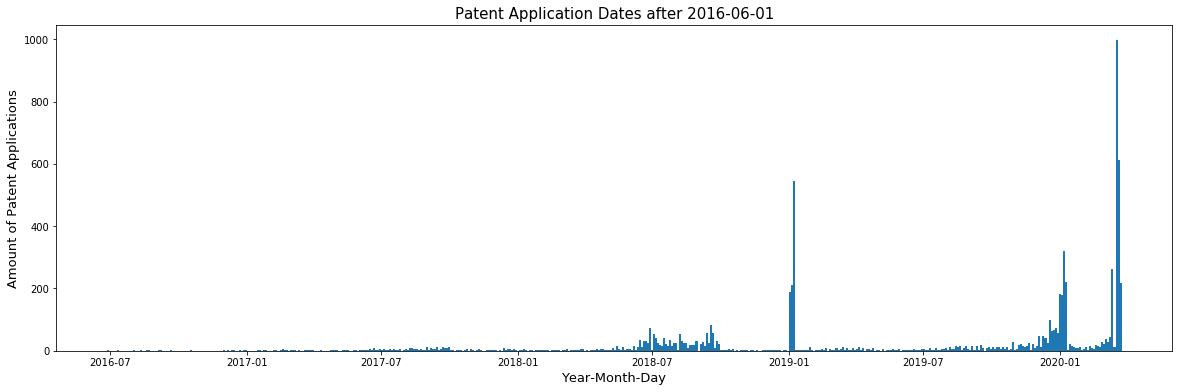

In [24]:
# Analyze datetime composition
plt.figure(figsize=(20,6))
plt.title('Patent Application Dates after 2016-06-01',fontsize = 15)
plt.xlabel('Year-Month-Day',fontsize = 13)
plt.ylabel('Amount of Patent Applications',fontsize = 13)
plt.hist(patent_df[patent_df['date-appl'] > pd.to_datetime('20160601')]['date-appl'], bins=500);

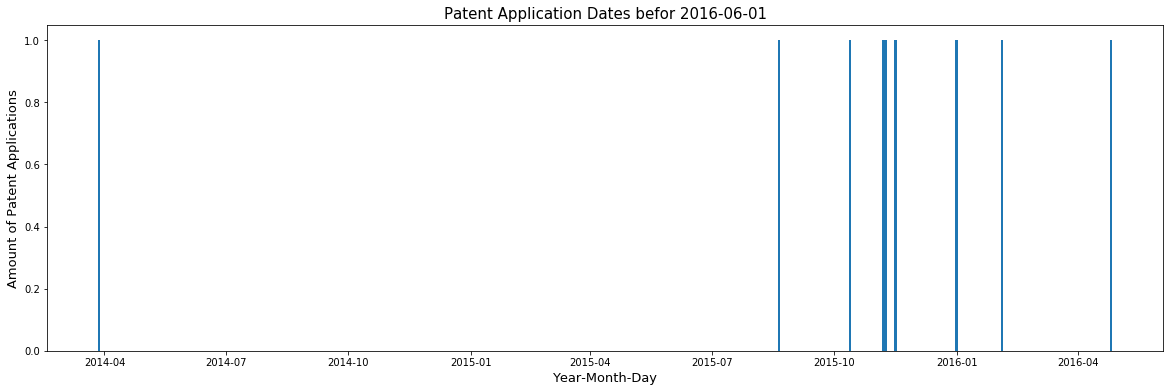

In [25]:
plt.figure(figsize=(20,6))
plt.title('Patent Application Dates befor 2016-06-01',fontsize = 15)
plt.xlabel('Year-Month-Day',fontsize = 13)
plt.ylabel('Amount of Patent Applications',fontsize = 13)
plt.hist(patent_df[patent_df['date-appl'] < pd.to_datetime('20160601')]['date-appl'], bins=400);

There are only few patent applications befor june 2016 in this test data set. Next, we want to check how diverse the patents are in regards to their section. While usually bar charts are prefered over pie charts, in this case lets mix it up with a pie chart.

In [31]:
def plotypieChart(input_df, col1, pieTitle):
    """
    Create a plotly figure of a Bar chart representing the different patent sections in the dataset.
    input:  a pandas dataframe, a string representing a column name and string as desired title
    output: plotly figure object containing the visualization
    """
    dummy_df = pd.DataFrame(input_df[col1].value_counts().reset_index().values, columns=[col1, "patentCount"])
    dummy_df = dummy_df.sort_values(by=[col1]).reset_index(drop=True)  

    
    return px.pie(dummy_df, values='patentCount', names= col1, title= pieTitle)

In [30]:
# Lets execute the function
plotypieChart(patent_df, "section",'CPC Patent Sections')

So the different patent sections are not equally represented in the dataset. This is something, we should keep in mind. Section Y is entirey missing. It would be additionally possible to create a sunburst diagram to further visualize the hierarchical structure of the cpc patent classification "Section/Class/Subclass/Group/Maingroup and subgroups", but the test dataset will not contain enough representatives. Lets look at the companies next:

In [43]:
# Lets get the number of companies
print('There are overall {} different companies in the data set.'.format(patent_df['company'].value_counts().shape[0]))
print('The companies listed by their number of patent applications in the data set are:')
patent_df['company'].value_counts()

There are overall 3653 different companies in the data set.
The companies listed by their number of patent applications in the data set are:


Samsung Electronics Co., Ltd.                  115
International Business Machines Corporation    100
SAMSUNG ELECTRONICS CO., LTD.                   76
INTERNATIONAL BUSINESS MACHINES CORPORATION     59
QUALCOMM Incorporated                           59
                                              ... 
Casale SA                                        1
PHARMAFLUIDICS NV                                1
SEOUL VIOSYS CO., LTD.                           1
Airgain Incorporated                             1
ZKW Group GmbH                                   1
Name: company, Length: 3653, dtype: int64

## 4) Modelling  and (5) Evaluation

In order to build a topic model for the patents, it is smart to create a model for each patent section. This requires the following steps:
* Load the raw data as dataframe
* Tokenize the data from the text column: Normalize cases, remove punctuation, special characters etc  (via the modules nltk and re)
* Build and optimize a model: This will be done via Sklearns LatentDirechletAllocation() and the Gridsearch functionality

Additionally it might be useful to wrap the model in an ML-pipeline. This step is described in the file train_LDA_model.py in the model folder.

## 6) Deployment

The dataset and the model will be deployed and visualized in a dashboard which is located in the App folder. The dashboard features ... as well as the results of the topic modelling for each patent section.